# Modelo de Optimización para la Demanda de Queso Costeño

El modelo de optimización presentado está diseñado para gestionar la demanda de queso costeño a través de una plataforma de marketing, utilizando múltiples centros de acopio. El objetivo principal es minimizar los costos asociados con el cumplimiento de la demanda del cliente, considerando los costos de transporte, tiempos de alistamiento y producción potencial en los centros de acopio.

**Variables del Problema**

**N**: Número de centros de acopio.

**CAi**: Identificador del centro de acopio i para i=0…N donde i≠p. Estos centros de acopio complementan las unidades de producto de la demanda que el centro de acopio principal no tiene disponibles. Los centros de acopio **CAi** despachan hacia el centro de acopio principal.

**CAp**: Identificador del centro de acopio principal p (**p**∈[0,N] y **p**≠i). Este centro de acopio atiende directamente al cliente y es responsable de enviar la demanda completa al cliente.

**K(CAi)**: Cantidad del producto que se despacha desde el centro de acopio **CAi**, incluyendo unidades en stock y unidades potenciales que pueden estar listas en poco tiempo.

**Precio(CAi)**: Precio por kilo del producto despachado desde el centro de acopio **CAi**.

**cTransp(CAi)**: Costo del transporte del pedido desde el centro de acopio **CAi** a su destino.

**TiempoAlistam(CAi)**: Tiempo en horas para alistar el pedido desde el centro de acopio **CAi** a su destino.

**TiempoMaxDefinido**: Tiempo máximo definido para considerar la producción potencial.

**TiempoTransp(CAi)**: Tiempo de transporte desde el centro de acopio **CAi** a su destino.

**Tiempo(CAi)**: Tiempo total en horas para que el pedido llegue desde el centro de acopio **CAi** a su destino, sumando el tiempo de alistamiento y el tiempo de transporte.

**cTiempo**: Costo adicional por cada unidad de tiempo contemplado en la variable **Tiempo(CAi)**.

**Demanda**: Cantidad de producto solicitada por el cliente.

**Stock(CAi)**: Stock del producto en el centro de acopio **CAi**.

**Ppotencial(CAi)**: Cantidad de producto que potencialmente puede estar disponible en poco tiempo (potencial del día).

*Código desarrollado para la resolución del problema*

# IMPORTACIONES

In [1429]:
from pyomo.environ import *
import pyomo.environ as pyo
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tabulate import tabulate
from prettytable import PrettyTable
import openpyxl

# ENTRADA DE DATOS

**demanda**: Cantidad de producto de acuerdo con la categoría del pedido a satisfacer.

**costo_transporte**: Costo por unidad de tiempo de espera para satisfacer la demanda.

**id**: Identificadores de Centro de Acopio (CAi).

**kg**: Stock del Producto en el Centro de Acopio (Stock(CAi)).

**produccion_potencial**: (Ppotencial(CAi)).

**costos_transporte**: (cTransp(CAi)).

**precio**: Precio del Producto por Kilo (Precio(CAi)).

**tiempos_transporte**:Tiempos de Transporte (TiempoTransp(CAi)).

**tiempo_alistamiento**:Tiempos de Alistamiento (TiempoAlistam(CAi)).

In [1430]:
centros_acopio_df = pd.read_excel('data/centros_acopio.xlsx')
tiempos_transporte_df = pd.read_excel('data/tiempos_transporte.xlsx')
costo_transporte_df = pd.read_excel('data/costo_transporte.xlsx')

# CREACIÓN DEL MODELO

In [1431]:
model = pyo.ConcreteModel()

# CONJUNTOS

In [1432]:
num_centros = len(centros_acopio_df)
model.I = pyo.RangeSet(0, num_centros - 1)

# PARAMETROS

In [1433]:
model.demanda = pyo.Param(initialize=60)
model.costo_tiempo = pyo.Param(initialize=100, mutable=True)
model.Stock = pyo.Param(model.I, initialize={i: centros_acopio_df.iloc[i]['Stock'] for i in model.I})
model.Ppotencial = pyo.Param(model.I, initialize={i: centros_acopio_df.iloc[i]['Ppotencial'] for i in model.I})
model.Precio = pyo.Param(model.I, initialize={i: centros_acopio_df.iloc[i]['Precio'] for i in model.I})
model.CTranspCli = pyo.Param(model.I, initialize={i: centros_acopio_df.iloc[i]['CtranspCli'] for i in model.I})
model.TiempoTranspCli = pyo.Param(model.I, initialize={i: centros_acopio_df.iloc[i]['TiempoTranspCli'] for i in model.I})
model.TiempoAlistam = pyo.Param(model.I, initialize={i: centros_acopio_df.iloc[i]['TiempoAlistam'] for i in model.I})
model.costos_transporte = pyo.Param(model.I, model.I, initialize={(i, j): costo_transporte_df.iloc[i, j+1] for i in model.I for j in model.I})
model.tiempos_transporte = pyo.Param(model.I, model.I, initialize={(i, j): tiempos_transporte_df.iloc[i, j+1] for i in model.I for j in model.I})
model.tiempo_maximo_definido = pyo.Param(initialize=360)

# SELECCIÓN DEL CENTRO DE ACOPIO PRINCIPAL

Selección automática del centro principal basado en el costo más bajo

In [1434]:
centro_principal_id = min(model.I, key=lambda i: model.CTranspCli[i])
model.CentroPrincipal = pyo.Param(initialize=centro_principal_id)

# VARIABLES

In [1435]:
model.X = pyo.Var(model.I, within=pyo.NonNegativeReals) # Cantidad despachada desde cada centro
model.Y = pyo.Var(model.I, model.I, within=pyo.NonNegativeReals) # Cantidad transportada entre centros

# FUNCIÓN OBJETIVO

\begin{equation}
\text{Minimizar} \quad \sum_{i=1, i \neq p}^{N} \left[ K(CAi) \cdot Precio(CAi) + K(CAi) \cdot cTransp(CAi) + Tiempo(CAi) \cdot cTiempo \right] + \left[ K(CAp) \cdot Precio(CAp) + Demanda \cdot cTransp(CAp) + Tiempo(CAp) \cdot cTiempo \right]
\end{equation}

La función objetivo para minimizar costos se puede desglosar en dos partes principales:

1. **Costo de los centros de acopio que no son el principal (i ≠ p):**
   
\begin{equation}
\quad \sum_{i=1, i \neq p}^{N} \left[ K(CAi) \cdot Precio(CAi) + K(CAi) \cdot cTransp(CAi) + Tiempo(CAi) \cdot cTiempo \right] +
\end{equation}

   - **K(CAi)** es el stock en el centro de acopio \( i \).
   - **Precio(CAi)** es el precio en el centro de acopio \( i \).
   - **cTransp(CAi** es el costo de transporte desde el centro de acopio \( i \).
   - **Tiempo(CAi)** es el tiempo asociado al centro de acopio \( i \).
   - **cTiempo** es el costo asociado al tiempo.

   *Este término representa el costo total de todos los centros de acopio que no son el principal.*

2. **Costo del centro de acopio principal (p):**

   
\begin{equation}
 \left[ K(CAp) \cdot Precio(CAp) + Demanda \cdot cTransp(CAp) + Tiempo(CAp) \cdot cTiempo \right]
\end{equation}
   

   - **K(CAp** es el stock en el centro de acopio principal.
   - **Precio(CAp)** es el precio en el centro de acopio principal.
   - **Demanda** es la demanda total.
   - **cTransp(CAp)** es el costo de transporte desde el centro de acopio principal.
   - **Tiempo(CAp)** es el tiempo asociado al centro de acopio principal.
   - **cTiempo** es el costo asociado al tiempo.

   *Este término representa el costo asociado al centro de acopio principal.*

In [1436]:
def objective_rule(model):
    return sum(
        model.X[i] * model.Precio[i] + 
        model.X[i] * model.CTranspCli[i] + 
        model.TiempoAlistam[i] * model.costo_tiempo 
        for i in model.I if i != model.CentroPrincipal
    ) + (
        model.X[model.CentroPrincipal] * model.Precio[model.CentroPrincipal] + 
        model.demanda * model.CTranspCli[model.CentroPrincipal] + 
        model.TiempoAlistam[model.CentroPrincipal] * model.costo_tiempo
    )

model.CostoTotal = pyo.Objective(rule=objective_rule, sense=pyo.minimize)

# RESTRICCIONES 

\begin{equation}
\sum_{i=0}^{N} K(CAi) = Demanda
\end{equation}

\begin{equation}
K(CAi) \leq Stock(CAi) + P_{\text{potencial}}(CAi) \quad \text{para } i=0\ldots N
\end{equation}

\begin{equation}
Tiempo(CAi) = Tiempo_{\text{Alistam}}(CAi) + Tiempo_{\text{Transp}}(CAi)
\end{equation}

\begin{equation}
Tiempo_{\text{Alistam}}(CAi) \leq Tiempo_{\text{MaxDefinido}} \quad \text{para } i=0\ldots N
\end{equation}

La restricciones funcionan de esta manera:

1. **Sumatoria del stock igual a la demanda total:**

\begin{equation}
\sum_{i=0}^{N} K(CAi) = Demanda
\end{equation}

   - **K(CAi)** es el stock en el centro de acopio \( i \).
   - **Demanda** es la demanda total.

   Esta ecuación asegura que la suma del stock disponible en todos los centros de acopio sea igual a la demanda total.

2. **Stock limitado por el inventario disponible y potencial:**

\begin{equation}
K(CAi) \leq Stock(CAi) + P_{\text{potencial}}(CAi) \quad \text{para } i=0\ldots N
\end{equation}

   - **K(CAi)** es el stock en el centro de acopio \( i \).
   - **Stock(CAi)** es el inventario disponible en el centro de acopio \( i \).
   - **P_potencial(CAi)** es el inventario potencial adicional que se puede obtener en el centro de acopio \( i \).

   Esta ecuación garantiza que el stock en cada centro de acopio no exceda la suma del inventario disponible y el inventario potencial adicional.

3. **Tiempo total en cada centro de acopio:**

\begin{equation}
Tiempo(CAi) = Tiempo_{\text{Alistam}}(CAi) + Tiempo_{\text{Transp}}(CAi)
\end{equation}

   - **Tiempo(CAi)** es el tiempo total asociado al centro de acopio \( i \).
   - **Tiempo_Alistam(CAi)** es el tiempo de alistamiento en el centro de acopio \( i \).
   - **Tiempo_Transp(CAi)** es el tiempo de transporte desde el centro de acopio \( i \).

   Esta ecuación define el tiempo total en cada centro de acopio como la suma del tiempo de alistamiento y el tiempo de transporte.

4. **Límite en el tiempo de alistamiento:**

\begin{equation}
Tiempo_{\text{Alistam}}(CAi) \leq Tiempo_{\text{MaxDefinido}} \quad \text{para } i=0\ldots N
\end{equation}

   - **Tiempo_Alistam(CAi)** es el tiempo de alistamiento en el centro de acopio \( i \).
   - **Tiempo_MaxDefinido** es el tiempo máximo permitido para el alistamiento.

   Esta ecuación asegura que el tiempo de alistamiento en cada centro de acopio no exceda el tiempo máximo permitido definido previamente.

In [1437]:
model.DemandaSatisfecha = pyo.Constraint(expr=sum(model.X[i] for i in model.I) == model.demanda)

model.CombinedStockPotential = pyo.Constraint(model.I, rule=lambda model, i: model.X[i] <= model.Stock[i] + model.Ppotencial[i])

model.TiempoMax = pyo.Constraint(model.I, rule=lambda model, i: model.TiempoAlistam[i] + sum(model.tiempos_transporte[i, j] * model.Y[i, j] for j in model.I) <= model.tiempo_maximo_definido)

model.BalanceTransport = pyo.Constraint(model.I, rule=lambda model, i: sum(model.Y[j, i] for j in model.I) == model.X[i] if i != model.CentroPrincipal else pyo.Constraint.Skip)

model.CentroPrincipalManejo = pyo.Constraint(expr=sum(model.Y[i, model.CentroPrincipal] for i in model.I) == model.X[model.CentroPrincipal])

# RESOLVER MODELO

In [1438]:
# Resolver el modelo inicialmente
solver = pyo.SolverFactory('glpk')
results = solver.solve(model)

# Calcular el costo total
Costo_Total = pyo.value(model.CostoTotal)

# Recalcular el costo de tiempo
costo_tiempo_actualizado = model.tiempo_maximo_definido() / Costo_Total

# Actualizar el parámetro y resolver nuevamente si es necesario
model.costo_tiempo.set_value(costo_tiempo_actualizado)
results = solver.solve(model, tee=True)


GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /tmp/tmpa3iq7d3p.glpk.raw --wglp /tmp/tmp1tfdwlxo.glpk.glp --cpxlp
 /tmp/tmpuzb62s74.pyomo.lp
Reading problem data from '/tmp/tmpuzb62s74.pyomo.lp'...
31 rows, 111 columns, 220 non-zeros
444 lines were read
Writing problem data to '/tmp/tmp1tfdwlxo.glpk.glp'...
398 lines were written
GLPK Simplex Optimizer 5.0
31 rows, 111 columns, 220 non-zeros
Preprocessing...
21 rows, 100 columns, 200 non-zeros
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  4.700e+01  ratio =  4.700e+01
GM: min|aij| =  7.118e-01  max|aij| =  1.405e+00  ratio =  1.974e+00
EQ: min|aij| =  5.080e-01  max|aij| =  1.000e+00  ratio =  1.968e+00
Constructing initial basis...
Size of triangular part is 21
      0: obj =   9.729000452e+05 inf =   3.878e+01 (1)
      3: obj =   2.191598545e+06 inf =   0.000e+00 (0)
*     4: obj =   1.981725545e+06 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Time used:   0.0 secs
Memory used: 0.1 Mb (113

# REPRESENTACIÓN DE DATOS


Representación de stocks:


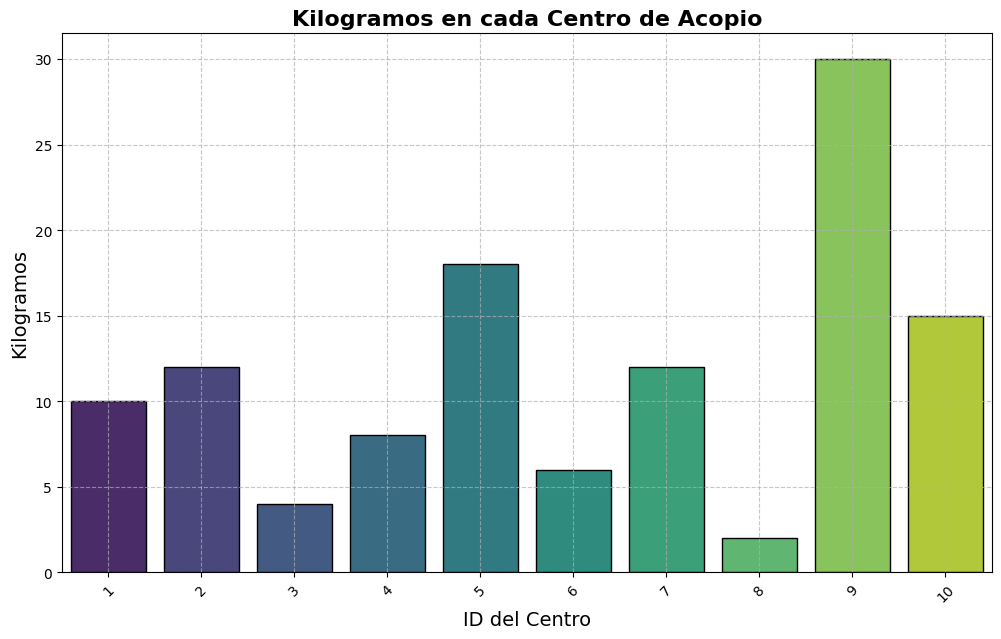

In [1439]:
print("\nRepresentación de stocks:")

df_centros = pd.DataFrame(datos['centros_acopio'])
plt.figure(figsize=(12, 7))
sns.barplot(x='Id_CA', y='Stock', data=df_centros, palette='viridis', edgecolor='black')
plt.title('Kilogramos en cada Centro de Acopio', fontsize=16, weight='bold')
plt.xlabel('ID del Centro', fontsize=14)
plt.ylabel('Kilogramos', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [1440]:
# Crear tabla para los centros de acopio
centros_acopio = datos["centros_acopio"]
headers = ["Id_CA", "Stock", "Ppotencial", "Precio", "CtranspCli", "TiempoTranspCli", "TiempoAlistam"]
table = [[c["Id_CA"], c["Stock"], c["Ppotencial"], c["Precio"], c["CtranspCli"], c["TiempoTranspCli"], c["TiempoAlistam"]] for c in centros_acopio]
print("Centros de Acopio:")
print(tabulate(table, headers=headers, tablefmt='grid'))
print()


# Mostrar costos de transporte en matriz
print("Matriz 'Costos de Transporte':")
print(tabulate(datos["costos_transporte"], tablefmt='grid'))
print()
# Crear tabla para la matriz de costos de transporte
table = PrettyTable()
table.field_names = [""] + [f"CA {i+1}" for i in range(len(datos["costos_transporte"]))]
for i, row in enumerate(datos["costos_transporte"]):
    table.add_row([f"CA {i+1}"] + row)

print("Tabla 'Costos de Transporte':")
print(table)
print()

# Mostrar tiempos de transporte
print("Matriz 'Tiempos de Transporte':")
print(tabulate(datos["tiempos_transporte"], tablefmt='grid'))
print()

# Crear tabla para la matriz de tiempos de transporte
table = PrettyTable()
table.field_names = [""] + [f"CA {i+1}" for i in range(len(datos["tiempos_transporte"]))]
for i, row in enumerate(datos["tiempos_transporte"]):
    table.add_row([f"CA {i+1}"] + row)

print("Tabla 'Tiempos de Transporte':")
print(table)
print()

# Mostrar costos y tiempos adicionales
print(f"Costo Tiempo: {model.costo_tiempo()}\n")
print(f"Tiempo Máximo Definido: {model.tiempo_maximo_definido()}")


Centros de Acopio:
+---------+---------+--------------+----------+--------------+-------------------+-----------------+
|   Id_CA |   Stock |   Ppotencial |   Precio |   CtranspCli |   TiempoTranspCli |   TiempoAlistam |
+=========+=========+==============+==========+==============+===================+=================+
|       1 |      10 |        0.5   |     5000 |        21841 |                37 |              10 |
+---------+---------+--------------+----------+--------------+-------------------+-----------------+
|       2 |      12 |        0.625 |    10000 |        21180 |                42 |               9 |
+---------+---------+--------------+----------+--------------+-------------------+-----------------+
|       3 |       4 |       14     |    15000 |        24132 |                32 |              47 |
+---------+---------+--------------+----------+--------------+-------------------+-----------------+
|       4 |       8 |       13     |     2000 |        14215 |          

# RESULTADOS

# Solución óptima

**Centros involucrados**

In [1441]:
centros_despachados = set()
print(f"Centros seleccionados para la operación:")

for i in model.I:
    for j in model.I:
        try:
            value_Y = pyo.value(model.Y[i, j])
            if value_Y > 0:
                centros_despachados.add(i)
                centros_despachados.add(j)
        except KeyError:
            print(f"Índice {i+1}, {j} no es válido para el componente model.Y.")
        except ValueError:
            print(f"Cantidad transportada de Centro {i+1} a Centro {j} no disponible")

for centro in centros_despachados:
    print(f"Centros {centro +1}")


Centros seleccionados para la operación:
Centros 1
Centros 2
Centros 3
Centros 4
Centros 8


**Cantidad asignada:**

In [1442]:
for i in model.I:
    try:
        print(f"Centro {i+1}: = {pyo.value(model.X[i]):.2f}")
    except ValueError:
        print(f"Centro {i+1}: Cantidad despachada no disponible")

Centro 1: = 10.50
Centro 2: = 12.62
Centro 3: = 1.38
Centro 4: = 21.00
Centro 5: = 0.00
Centro 6: = 0.00
Centro 7: = 0.00
Centro 8: = 14.50
Centro 9: = 0.00
Centro 10: = 0.00


**Centro principal para la demanda del cliente**

In [1443]:
print(f"\nCentro principal seleccionado: {model.CentroPrincipal.value + 1}")


Centro principal seleccionado: 4


**Resumen de operación al centro principal**

In [1444]:
total_costo_transporte = 0
centros_despachados = set()

for i in model.I:
    if i != model.CentroPrincipal:
        try:
            cantidad_transportada = sum(pyo.value(model.Y[i, j]) for j in model.I if model.Y[i, j].value is not None and pyo.value(model.Y[i, j]) > 0)
            if cantidad_transportada > 0:
                costo_transportado = cantidad_transportada * model.costos_transporte[i, model.CentroPrincipal]
                total_costo_transporte += costo_transportado
                centros_despachados.add(i)
                print(f'\nCentro {i+1}: Despachado = {model.X[i].value:.2f}. \nCantidad para transportar al centro principal {model.CentroPrincipal.value +1} = {cantidad_transportada:.2f}. \nCosto transporte = ${costo_transportado:.2f}\n')
            else:
                print(f'Centro {i+1}: No hay cantidad a transportar al centro principal')
        except ValueError:
            print(f'Centro {i+1}: Despachado o cantidad transportada no disponible')

nombres_centros = ['Centro 1', 'Centro 2', 'Centro 3', 'Centro 4', 'Centro 5', 'Centro 6', 'Centro 7', 'Centro 8', 'Centro 9', 'Centro 10']

# Mostrar los centros despachados con nombres en el orden original
print(f'\nCentros por despachar: {[nombres_centros[i] for i in centros_despachados]}')


Centro 1: Despachado = 10.50. 
Cantidad para transportar al centro principal 4 = 10.50. 
Costo transporte = $303051.00


Centro 2: Despachado = 12.62. 
Cantidad para transportar al centro principal 4 = 12.62. 
Costo transporte = $162824.62


Centro 3: Despachado = 1.38. 
Cantidad para transportar al centro principal 4 = 1.38. 
Costo transporte = $32594.38

Centro 5: No hay cantidad a transportar al centro principal
Centro 6: No hay cantidad a transportar al centro principal
Centro 7: No hay cantidad a transportar al centro principal

Centro 8: Despachado = 14.50. 
Cantidad para transportar al centro principal 4 = 14.50. 
Costo transporte = $174594.50

Centro 9: No hay cantidad a transportar al centro principal
Centro 10: No hay cantidad a transportar al centro principal

Centros por despachar: ['Centro 1', 'Centro 2', 'Centro 3', 'Centro 8']


**Costo total del producto**

In [1445]:
print(f"\nCosto total del modelo de optimización: = ${pyo.value(model.CostoTotal):,.2f}")


Costo total del modelo de optimización: = $1,981,725.55


**Costo total del transporte centros a centro principal**

In [1446]:
print(f"\n\nCosto total del transporte centros a centro principal: = ${total_costo_transporte:.2f}")



Costo total del transporte centros a centro principal: = $673064.50
